# Project03_Deep Learning

## Step 0: Data (MNIST in PyTorch & face data in project_01)

In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
from torch.utils.data.sampler import SubsetRandomSampler

### MNIST data

Transform that allows images to have the same dimensions and properties.

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

Using MNIST data and  loading them to DataLoader, 
which combines the dataset and a sampler and provides single or multi-process iterators over the dataset.

In [3]:
trainset = datasets.MNIST('PATH_TO_STORE_TRAINSET', download=True, train=True, transform=transform)
valset = datasets.MNIST('PATH_TO_STORE_TESTSET', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

Visualize data

In [4]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


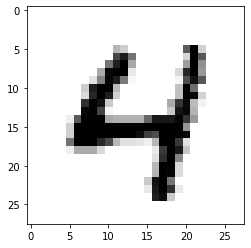

In [5]:
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r');

Visualize more data

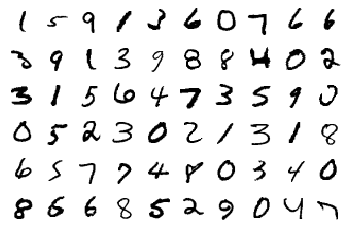

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

Build up neural network, to start with, we simply select 3 fully connected layers, input size is 784 since MNIST with size 28x28

In [7]:
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax()
)


Define loss

In [8]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

In [9]:
print('Before backward pass: \n', model[0].weight.grad)
loss.backward()
print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[ 0.0116,  0.0116,  0.0116,  ...,  0.0116,  0.0116,  0.0116],
        [-0.0037, -0.0037, -0.0037,  ..., -0.0037, -0.0037, -0.0037],
        [-0.0001, -0.0001, -0.0001,  ..., -0.0001, -0.0001, -0.0001],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0009,  0.0009,  0.0009,  ...,  0.0009,  0.0009,  0.0009],
        [-0.0016, -0.0016, -0.0016,  ..., -0.0016, -0.0016, -0.0016]])


Training the model

In [10]:
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
epochs = 15
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 0.6476539332570552
Epoch 1 - Training loss: 0.2859602959822617
Epoch 2 - Training loss: 0.22112437781256272
Epoch 3 - Training loss: 0.17709568647870313
Epoch 4 - Training loss: 0.14861088817808102
Epoch 5 - Training loss: 0.1272416094870074
Epoch 6 - Training loss: 0.11129791419734673
Epoch 7 - Training loss: 0.09862621662530627
Epoch 8 - Training loss: 0.0881488967005775
Epoch 9 - Training loss: 0.07932521964409459
Epoch 10 - Training loss: 0.07218121401647896
Epoch 11 - Training loss: 0.06615937205809932
Epoch 12 - Training loss: 0.060576221690193485
Epoch 13 - Training loss: 0.05467517364835704
Epoch 14 - Training loss: 0.050556592003845456

Training Time (in minutes) = 3.3018833875656126


Training process is relatively low. Testing on the validation set

In [11]:
images, labels = next(iter(valloader))

img = images[0].view(1, 784)
with torch.no_grad():
    logps = model(img)

ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))

Predicted Digit = 5


True label is:

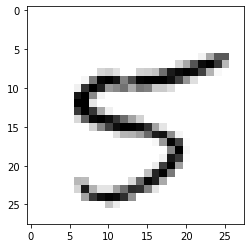

In [12]:
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r');

Iterate through all validation set and calculate the validation accuracy

In [13]:
correct_count, all_count = 0, 0
for images,labels in valloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    with torch.no_grad():
        logps = model(img)

    
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.973


Now let's test on our own face dataset.

### Face Dataset from project01

Face dataset is stored in the same path of Notebook, and named "images", there are two folders in the images:
    0.nonface
    1.face
Each picture is sized to 3x28x28, totally we have 1000 face pictures and 1000 nonface pifctures, load these data.

In [14]:
train_data = datasets.ImageFolder('images',transform=transform)

Seperate data set into training set validation set, and testset. 

In [15]:
num_data = len(train_data)
indices_data = list(range(num_data))
np.random.shuffle(indices_data)
split_tt = int(np.floor(0.1 * num_data))
train_idx, test_idx = indices_data[split_tt:], indices_data[:split_tt]

In [16]:
num_train = len(train_idx)
indices_train = list(range(num_train))
np.random.shuffle(indices_train)
split_tv = int(np.floor(0.25 * num_train))
train_idx, valid_idx = indices_train[split_tv:],indices_train[:split_tv]

In [17]:
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [18]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, sampler=train_sampler, num_workers=1)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=32, sampler=valid_sampler, num_workers=1)
test_loader = torch.utils.data.DataLoader(train_data, batch_size=32, sampler = test_sampler, num_workers=1)

Visualize our face dataset

In [19]:
face_dataiter = iter(train_loader)
fake_img, labels = face_dataiter.next()
images = fake_img[:,0,:,:]
print(images.shape)
print(labels.shape)

torch.Size([32, 28, 28])
torch.Size([32])


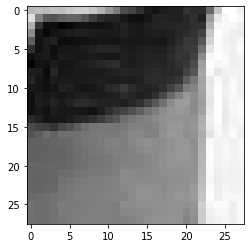

In [20]:
plt.imshow(images[1].numpy().squeeze(), cmap='binary_r');

Visualize more face data.

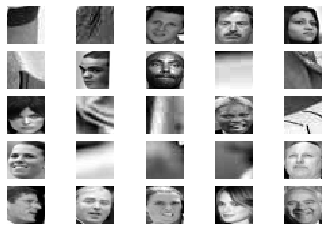

In [21]:
figure = plt.figure()
num_of_images = 25
for index in range(1, num_of_images + 1):
    plt.subplot(5, 5, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(),cmap = 'binary_r')

Due to figure size is 3x28x28, so the input size will be 2352, still keep the other model structure the same
Output size became 2, since it is a binary classification.

In [22]:
input_sizez = 2352
hidden_sizes = [128, 64]
output_size = 2
model = nn.Sequential(nn.Linear(input_sizez, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=2352, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=2, bias=True)
  (5): LogSoftmax()
)


In [23]:
criterion = nn.NLLLoss()
images, labels = next(iter(train_loader))
images = images.view(images.shape[0], -1)
logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

In [24]:
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
epochs = 10
for e in range(epochs):
    running_loss = 0
    for images, labels in train_loader:
        # Flatten face images into a 2352 long vector
        images = images.view(images.shape[0], -1)
        # Training pass
        optimizer.zero_grad() 
        output = model(images)
        loss = criterion(output, labels)
        #This is where the model learns by backpropagating
        loss.backward()
        #And optimizes its weights here
        optimizer.step()
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(train_loader)))
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 0.595634717580884
Epoch 1 - Training loss: 0.39489108116127725
Epoch 2 - Training loss: 0.28415884961222493
Epoch 3 - Training loss: 0.22575561355712803
Epoch 4 - Training loss: 0.1900186504042426
Epoch 5 - Training loss: 0.15559213660484136
Epoch 6 - Training loss: 0.13352907479329165
Epoch 7 - Training loss: 0.1268452541079632
Epoch 8 - Training loss: 0.10481961062827776
Epoch 9 - Training loss: 0.09532979702533678

Training Time (in minutes) = 0.303702720006307


Now let's test on testset. 0 is nonface, 1 is face

In [25]:
test_images, test_labels = next(iter(test_loader))
img = test_images[0].view(1, 2352)
with torch.no_grad():
    logps = model(img)

ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted =", probab.index(max(probab)))

Predicted = 0


True label is:

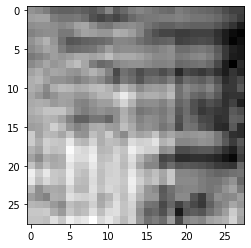

In [26]:
plt.imshow(test_images[0,0,:,:].numpy().squeeze(), cmap='binary_r');

Correct, iterate through all testset and check the accuracy.

In [27]:
correct_count, all_count = 0, 0
for test_images,labels in test_loader:
  for i in range(len(labels)):
    img = test_images[i].view(1, 2352)
    with torch.no_grad():
        logps = model(img)
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1
print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 200

Model Accuracy = 0.97


Accuracy is so high! Actually our facedata is properly croped, so it cotains relatively few noise for model to train.
Next step, we are trying to add more noise to face dataset and check how it influence the results.

## Step 1: preprocess the data and select a data augment scheme.

In [28]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomPerspective(),
    transforms.ColorJitter(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [29]:
train_data = datasets.ImageFolder('images',transform=transform)
num_data = len(train_data)
indices_data = list(range(num_data))
np.random.shuffle(indices_data)
split_tt = int(np.floor(0.1 * num_data))
train_idx, test_idx = indices_data[split_tt:], indices_data[:split_tt]

In [30]:
num_train = len(train_idx)
indices_train = list(range(num_train))
np.random.shuffle(indices_train)
split_tv = int(np.floor(0.25 * num_train))
train_idx, valid_idx = indices_train[split_tv:],indices_train[:split_tv]

In [31]:
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [32]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, sampler=train_sampler, num_workers=1)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=32, sampler=valid_sampler, num_workers=1)
test_loader = torch.utils.data.DataLoader(train_data, batch_size=32, sampler = test_sampler, num_workers=1)

In [33]:
face_dataiter = iter(train_loader)
fake_img, labels = face_dataiter.next()
images = fake_img[:,0,:,:]
print(images.shape)
print(labels.shape)

torch.Size([32, 28, 28])
torch.Size([32])


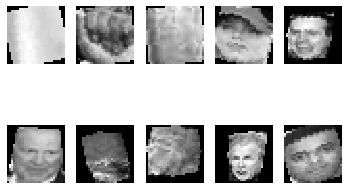

In [34]:
figure = plt.figure()
num_of_images = 10
for index in range(1, num_of_images + 1):
    plt.subplot(2, 5, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(),cmap = 'binary_r')

In [35]:
labels

tensor([1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0,
        0, 1, 1, 1, 1, 0, 0, 0])

## Step 2: Choose the architecture

In [36]:
input_sizez = 2352
hidden_sizes = [128, 64]
output_size = 2
model = nn.Sequential(nn.Linear(input_sizez, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=2352, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=2, bias=True)
  (5): LogSoftmax()
)


In [37]:
criterion = nn.NLLLoss()
images, labels = next(iter(train_loader))
images = images.view(images.shape[0], -1)
logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

In [38]:
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
epochs = 20
print_every = 20
running_loss = 0
steps = 0
t_accuracy = 0
train_losses, valid_losses = [], []
train_accuracy, valid_accuracy = [], []
for epoch in range(epochs):
    for images, labels in train_loader:
        # Flatten images into a 2352 long vector
        steps += 1
        images = images.view(images.shape[0], -1)
        # Training pass
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        #This is where the model learns by backpropagating
        loss.backward()
        #And optimizes its weights here
        optimizer.step()
        running_loss += loss.item()
        prediction = torch.exp(output)
        t_top_p, t_top_class = prediction.topk(1, dim=1)
        equality = t_top_class == labels.view(*t_top_class.shape)
        t_accuracy += torch.mean(equality.type(torch.FloatTensor)).item()
        if steps % print_every == 0:
            valid_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for valid_images, labels in valid_loader:
                    valid_images = valid_images.view(valid_images.shape[0], -1)
                    valid_output = model(valid_images)
                    batch_loss = criterion(valid_output, labels)
                    valid_loss += batch_loss.item()
                    ps = torch.exp(valid_output)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/print_every)
            valid_losses.append(valid_loss/len(valid_loader))
            train_accuracy.append(t_accuracy/print_every)
            valid_accuracy.append(accuracy/len(valid_loader))
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Train accuracy: {t_accuracy/print_every:.3f}.."
                  f"Validation loss: {valid_loss/len(valid_loader):.3f}.."
                  f"Validation accuracy: {accuracy/len(valid_loader):.3f}")
            running_loss = 0
            t_accuracy = 0
            model.train()
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 1/20.. Train loss: 0.666.. Train accuracy: 0.623..Validation loss: 0.638..Validation accuracy: 0.598
Epoch 1/20.. Train loss: 0.616.. Train accuracy: 0.641..Validation loss: 0.575..Validation accuracy: 0.698
Epoch 2/20.. Train loss: 0.556.. Train accuracy: 0.719..Validation loss: 0.534..Validation accuracy: 0.715
Epoch 2/20.. Train loss: 0.561.. Train accuracy: 0.705..Validation loss: 0.504..Validation accuracy: 0.756
Epoch 3/20.. Train loss: 0.524.. Train accuracy: 0.749..Validation loss: 0.537..Validation accuracy: 0.704
Epoch 3/20.. Train loss: 0.490.. Train accuracy: 0.762..Validation loss: 0.476..Validation accuracy: 0.758
Epoch 4/20.. Train loss: 0.506.. Train accuracy: 0.756..Validation loss: 0.460..Validation accuracy: 0.787
Epoch 4/20.. Train loss: 0.480.. Train accuracy: 0.786..Validation loss: 0.495..Validation accuracy: 0.762
Epoch 5/20.. Train loss: 0.478.. Train accuracy: 0.760..Validation loss: 0.454..Validation accuracy: 0.794
Epoch 5/20.. Train loss: 0.470.. Trai

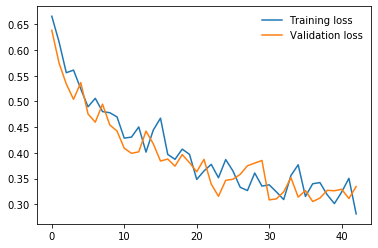

In [39]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

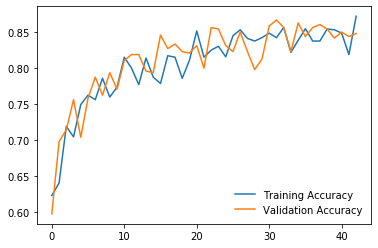

In [40]:
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(valid_accuracy, label='Validation Accuracy')
plt.legend(frameon=False)
plt.show()

In [41]:
test_images, test_labels = next(iter(test_loader))
img = test_images[0].view(1, 2352)
with torch.no_grad():
    logps = model(img)

ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))

Predicted Digit = 0


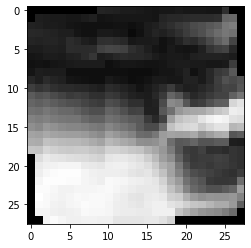

In [42]:
plt.imshow(test_images[0,0,:,:].numpy().squeeze(), cmap='binary_r');

In [43]:
correct_count, all_count = 0, 0
for test_images,labels in test_loader:
  for i in range(len(labels)):
    img = test_images[i].view(1, 2352)
    with torch.no_grad():
        logps = model(img)
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1
print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 200

Model Accuracy = 0.835
